In [1]:
import pandas as pd
df = pd.read_csv('/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/datasets/cicids2017/all_data.csv')
df.head()

/tmp/ipykernel_1770/70282118.py:2: DtypeWarning: Columns (84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/datasets/cicids2017/all_data.csv')


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,External IP
0,228571,7953,80,2751,49188,6,12231,4,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,0.0
1,228571,7953,80,2751,49188,6,12231,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,0.0
2,228571,7953,80,2751,49188,6,12231,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,0.0
3,228571,7953,80,2751,49188,6,12231,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,0.0
4,55580,7951,80,2743,49486,6,12232,3,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,0.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2672997 entries, 0 to 2672996
Data columns (total 85 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   Flow ID                      int64   
 1   Source IP                    int64   
 2   Source Port                  int64   
 3   Destination IP               int64   
 4   Destination Port             int64   
 5   Protocol                     int64   
 6   Timestamp                    int64   
 7   Flow Duration                int64   
 8   Total Fwd Packets            int64   
 9   Total Backward Packets       int64   
 10  Total Length of Fwd Packets  float64 
 11  Total Length of Bwd Packets  float64 
 12  Fwd Packet Length Max        float64 
 13  Fwd Packet Length Min        float64 
 14  Fwd Packet Length Mean       float64 
 15  Fwd Packet Length Std        float64 
 16  Bwd Packet Length Max        float64 
 17  Bwd Packet Length Min        float64 
 18  Bwd Packet Length Mean

In [36]:
import os
import pandas as pd
import numpy as np
import torch
import torch_geometric
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def prepare_gnn_type2_graph(df, binary_classification=False):
    """
    Create a graph where nodes are defined by (Source IP, Source Port) and (Dest IP, Dest Port)
    Edges represent flows with flow features
    
    Parameters:
    df (pd.DataFrame): Input dataframe with network flow data
    binary_classification (bool): Whether to convert to binary classification
    
    Returns:
    torch_geometric.data.Data: Graph data object
    """
    # Prepare labels
    label_encoder = LabelEncoder()
    if binary_classification:
        # Convert to binary (assumes 'Malicious' vs 'Benign')
        df['Label'] = df['Label'].map(lambda x: 1 if x == 'BENIGN' else 0)
        labels = torch.tensor(df['Label'].values, dtype=torch.long)
    else:
        # Multi-class encoding
        labels = torch.tensor(label_encoder.fit_transform(df['Label']), dtype=torch.long)
    
    # Create unique node mapping
    unique_nodes = set()
    for _, row in df.iterrows():
        unique_nodes.add((row['Source IP'], row['Source Port']))
        unique_nodes.add((row['Destination IP'], row['Destination Port']))
    
    # Map nodes to indices
    node_to_index = {node: idx for idx, node in enumerate(unique_nodes)}
    
    # Prepare edge indices
    edge_indices = []
    edge_features = []
    
    # Select relevant features for edge features
    edge_feature_cols = [
        'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 
        'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 
        'Flow Bytes/s', 'Flow Packets/s'
    ]
    
    for _, row in df.iterrows():
        source_node = (row['Source IP'], row['Source Port'])
        dest_node = (row['Destination IP'], row['Destination Port'])
        
        source_idx = node_to_index[source_node]
        dest_idx = node_to_index[dest_node]
        
        edge_indices.append([source_idx, dest_idx])
        
        # Extract edge features
        edge_features.append([row[col] for col in edge_feature_cols])
    
    # Convert to tensors
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_feat = torch.tensor(edge_features, dtype=torch.float)
    
    # Node features (could be IP address or port-based features)
    node_features = []
    for node in unique_nodes:
        # Ensure consistent feature dimensionality
        node_features.append([node[0], node[1], 0, 0, 0])
    node_feat = torch.tensor(node_features, dtype=torch.float)
    
    # Create PyG Data object
    data = Data(x=node_feat, edge_index=edge_index, edge_attr=edge_feat, y=labels)
    
    return data

def prepare_gnn_type1_graph(df, binary_classification=False):
    """
    Create a graph where hosts are nodes and flows are nodes
    Connects hosts through flow nodes
    
    Parameters:
    df (pd.DataFrame): Input dataframe with network flow data
    binary_classification (bool): Whether to convert to binary classification
    
    Returns:
    torch_geometric.data.Data: Graph data object
    """
    # Prepare labels
    label_encoder = LabelEncoder()
    if binary_classification:
        # Convert to binary (assumes 'Malicious' vs 'Benign')
        df['Label'] = df['Label'].map(lambda x: 1 if x == 'BENIGN' else 0)
        labels = torch.tensor(df['Label'].values, dtype=torch.long)
    else:
        # Multi-class encoding
        labels = torch.tensor(label_encoder.fit_transform(df['Label']), dtype=torch.long)
    
    # Create unique host nodes
    unique_hosts = set()
    for _, row in df.iterrows():
        unique_hosts.add(row['Source IP'])
        unique_hosts.add(row['Destination IP'])
    
    # Map hosts to indices
    host_to_index = {host: idx for idx, host in enumerate(unique_hosts)}
    
    # Prepare nodes and edges
    edge_indices = []
    
    # Track flow nodes
    flow_feature_cols = [
        'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 
        'Total Length of Fwd Packets', 'Total Length of Bwd Packets'
    ]
    
    # Prepare node features
    host_features = []
    flow_features = []
    
    # Add host features
    for host in unique_hosts:
        # Ensure consistent feature dimensionality
        host_features.append([host, 0, 0, 0, 0])
    
    # Add flow nodes and connect to source/dest hosts
    flow_offset = len(unique_hosts)
    for idx, row in df.iterrows():
        # Source host to flow
        source_host_idx = host_to_index[row['Source IP']]
        flow_node_idx = flow_offset + idx
        edge_indices.append([source_host_idx, flow_node_idx])
        
        # Flow to destination host
        dest_host_idx = host_to_index[row['Destination IP']]
        edge_indices.append([flow_node_idx, dest_host_idx])
        
        # Flow node features
        flow_features.append([row[col] for col in flow_feature_cols])
    
    # Combine node features
    node_features = torch.tensor(host_features + flow_features, dtype=torch.float)
    
    # Convert to tensors
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    
    # Create PyG Data object
    data = Data(x=node_features, edge_index=edge_index, y=labels)
    
    return data

def prepare_dataset(df, binary_classification=False, test_size=0.2, random_state=42, save_path=None):
    """
    Prepare train and test datasets for both graph types
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    binary_classification (bool): Whether to convert to binary classification
    test_size (float): Proportion of dataset to include in test split
    random_state (int): Random state for reproducibility
    save_path (str, optional): Directory to save graph data
    
    Returns:
    tuple: ((train_graph_type1, test_graph_type1), (train_graph_type2, test_graph_type2))
    """
    # Preprocess data
    df = df.dropna()  # Remove any rows with missing values
    
    # Split data
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['Label'])
    
    # Create graphs for both types
    train_graph_type2 = prepare_gnn_type2_graph(train_df, binary_classification)
    test_graph_type2 = prepare_gnn_type2_graph(test_df, binary_classification)
    train_graph_type1 = prepare_gnn_type1_graph(train_df, binary_classification)
    test_graph_type1 = prepare_gnn_type1_graph(test_df, binary_classification)
    
    # Save graphs if path is provided
    if save_path:
        # Ensure directory exists
        os.makedirs(save_path, exist_ok=True)
        
        # Save type 1 graphs
        torch.save(train_graph_type1, os.path.join(save_path, 'train_graph_type1.pt'))
        torch.save(test_graph_type1, os.path.join(save_path, 'test_graph_type1.pt'))
        
        # Save type 2 graphs
        torch.save(train_graph_type2, os.path.join(save_path, 'train_graph_type2.pt'))
        torch.save(test_graph_type2, os.path.join(save_path, 'test_graph_type2.pt'))
    
    return (train_graph_type1, test_graph_type1), (train_graph_type2, test_graph_type2)

# Example usage
if __name__ == "__main__":
    # Create synthetic data
    np.random.seed(42)
    
    # # Create synthetic data with multiple classes
    # data = {
    #     'Source IP': np.random.randint(1, 255, 100),
    #     'Source Port': np.random.randint(1000, 9999, 100),
    #     'Destination IP': np.random.randint(1, 255, 100),
    #     'Destination Port': np.random.randint(1000, 9999, 100),
    #     'Flow Duration': np.random.randint(10, 1000, 100),
    #     'Total Fwd Packets': np.random.randint(1, 50, 100),
    #     'Total Backward Packets': np.random.randint(1, 50, 100),
    #     'Total Length of Fwd Packets': np.random.rand(100) * 1000,
    #     'Total Length of Bwd Packets': np.random.rand(100) * 1000,
    #     'Flow Bytes/s': np.random.randint(100, 10000, 100),
    #     'Flow Packets/s': np.random.randint(10, 100, 100),
    #     'Label': np.random.choice(['Malicious', 'Benign', 'Suspicious'], 100)
    # }
    sampled_df = pd.read_csv('/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/datasets/cicids2017/all_data.csv')
    df = pd.DataFrame(sampled_df)
    
    # Prepare dataset with multi-class labels
    (train_graph_type1, test_graph_type1), (train_graph_type2, test_graph_type2) = prepare_dataset(
        df, 
        binary_classification=False,  # Multi-class classification
        save_path='/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/datasets/cicids2017/graphs'  # Optional: save graphs
    )
    
    # Print graph information
    print("Multi-class Graphs:")
    print("\nGraph Type 1 (Train):")
    print(f"Number of nodes: {train_graph_type1.num_nodes}")
    print(f"Number of edges: {train_graph_type1.num_edges}")
    print(f"Node features shape: {train_graph_type1.x.shape}")
    print(f"Number of unique labels: {len(torch.unique(train_graph_type1.y))}")
    
    # Repeat for binary classification
    (train_graph_type1, test_graph_type1), (train_graph_type2, test_graph_type2) = prepare_dataset(
        df, 
        binary_classification=True,  # Binary classification
        save_path='/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/datasets/cicids2017/binary_graphs'  # Optional: save graphs
    )
    
    print("\nBinary-class Graphs:")
    print("\nGraph Type 1 (Train):")
    print(f"Number of nodes: {train_graph_type1.num_nodes}")
    print(f"Number of edges: {train_graph_type1.num_edges}")
    print(f"Node features shape: {train_graph_type1.x.shape}")
    print(f"Number of unique labels: {len(torch.unique(train_graph_type1.y))}")

Multi-class Graphs:

Graph Type 1 (Train):
Number of nodes: 8868
Number of edges: 14612
Node features shape: torch.Size([8868, 5])
Number of unique labels: 12

Binary-class Graphs:

Graph Type 1 (Train):
Number of nodes: 8868
Number of edges: 14612
Node features shape: torch.Size([8868, 5])
Number of unique labels: 1


/tmp/ipykernel_2352/2403798126.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


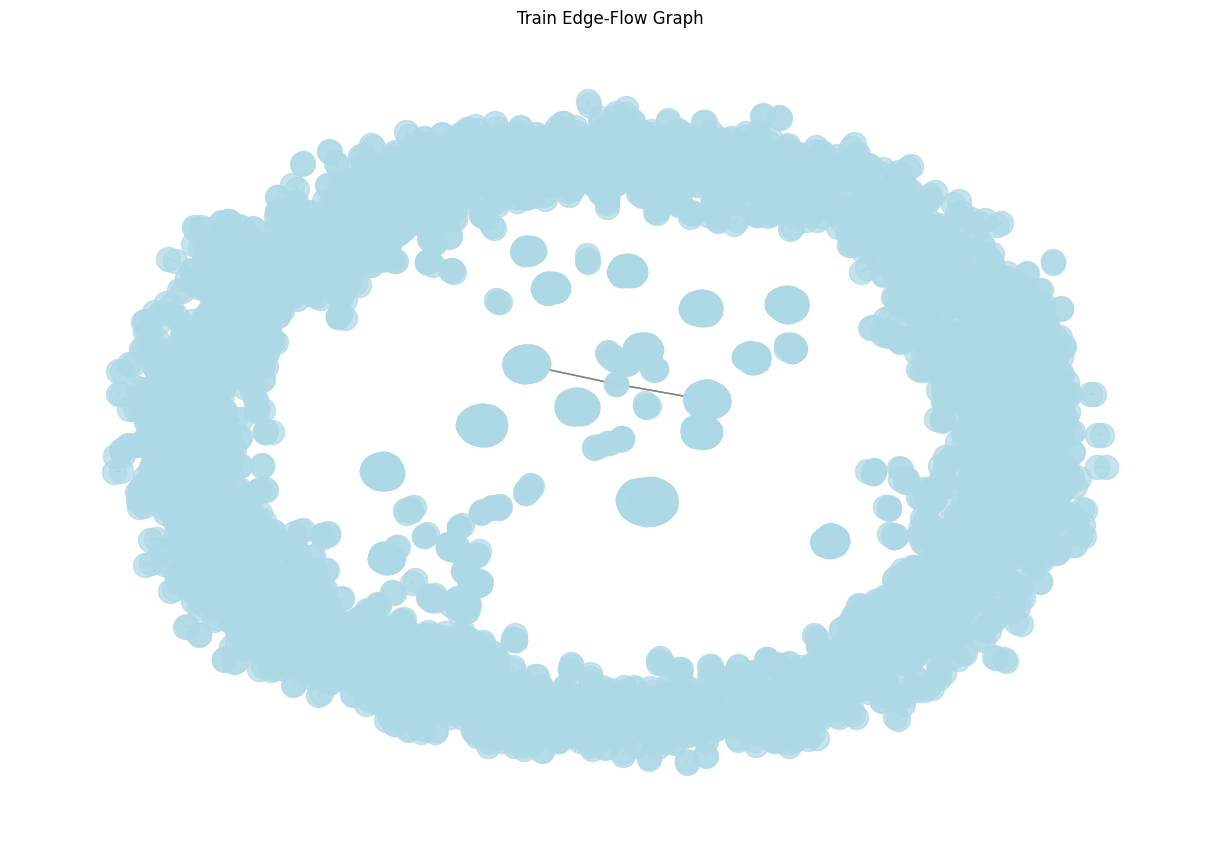

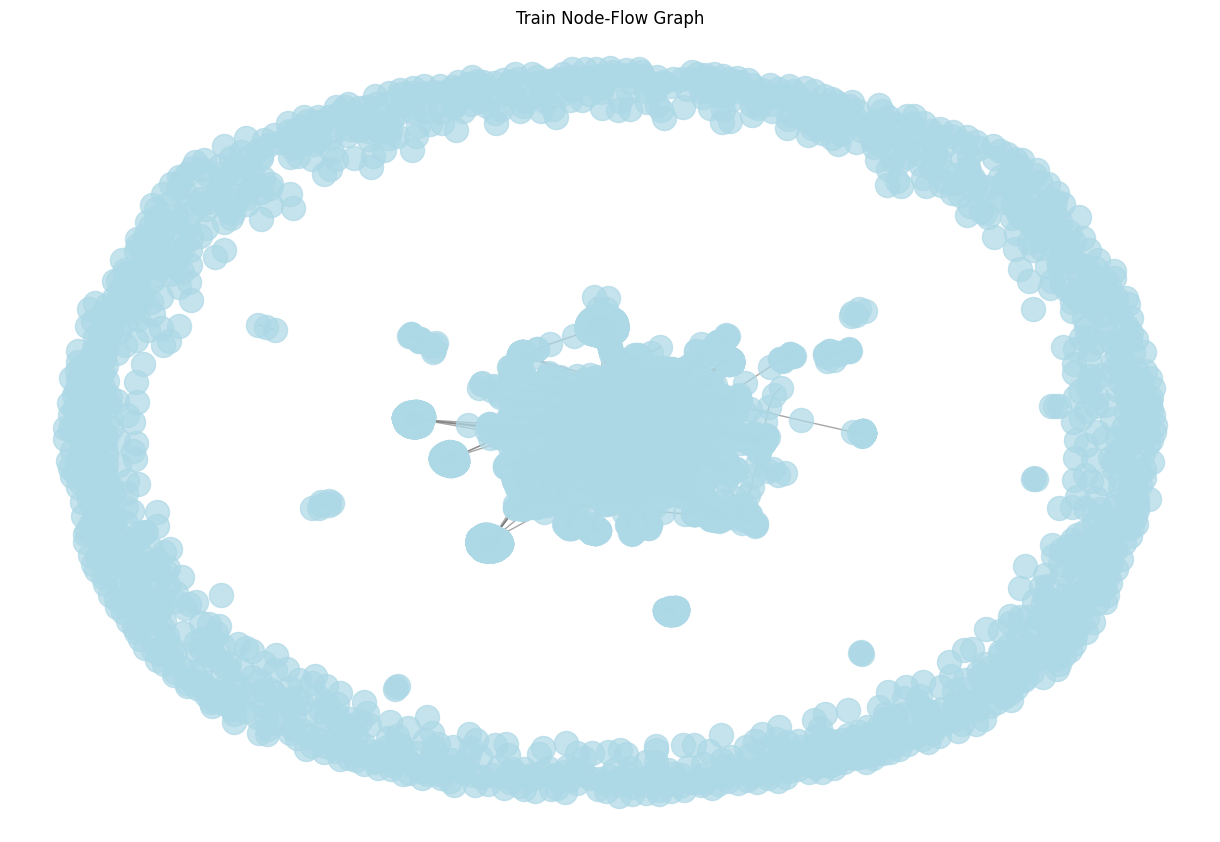

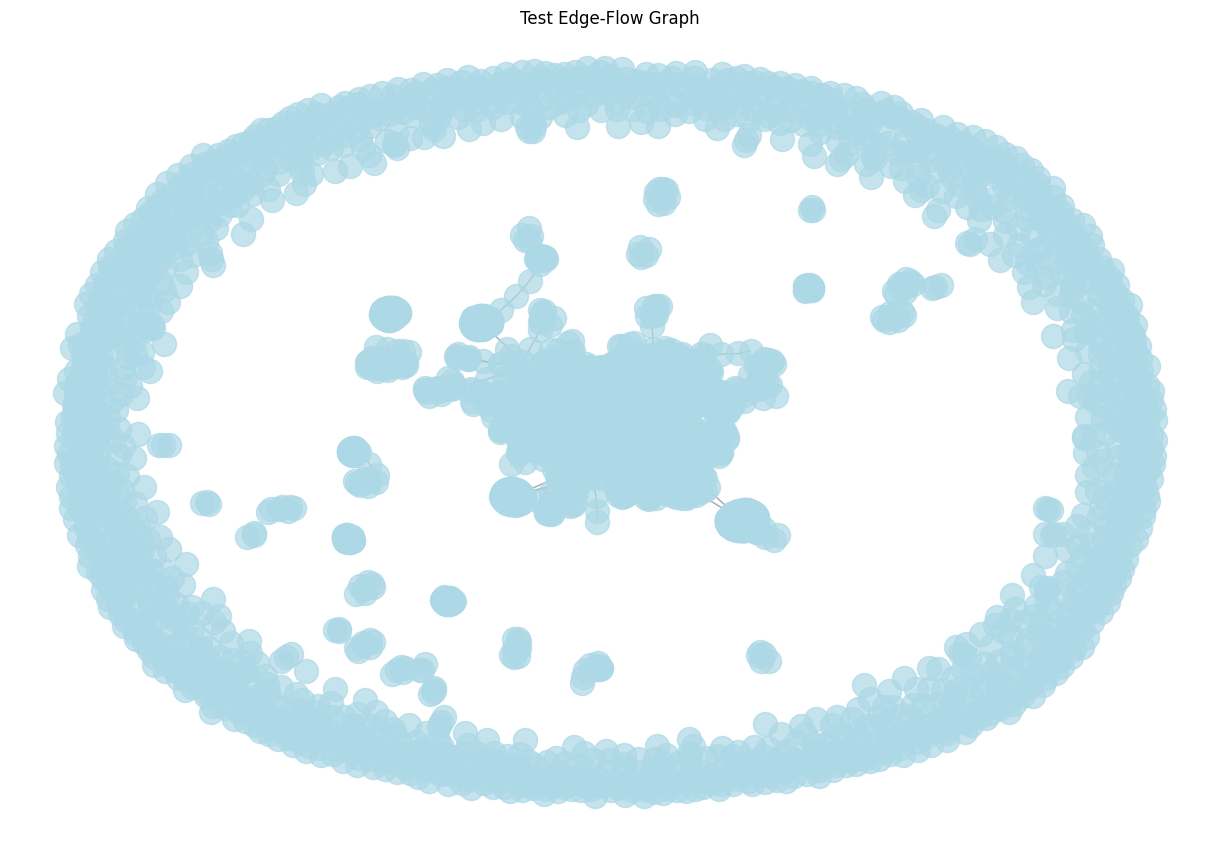

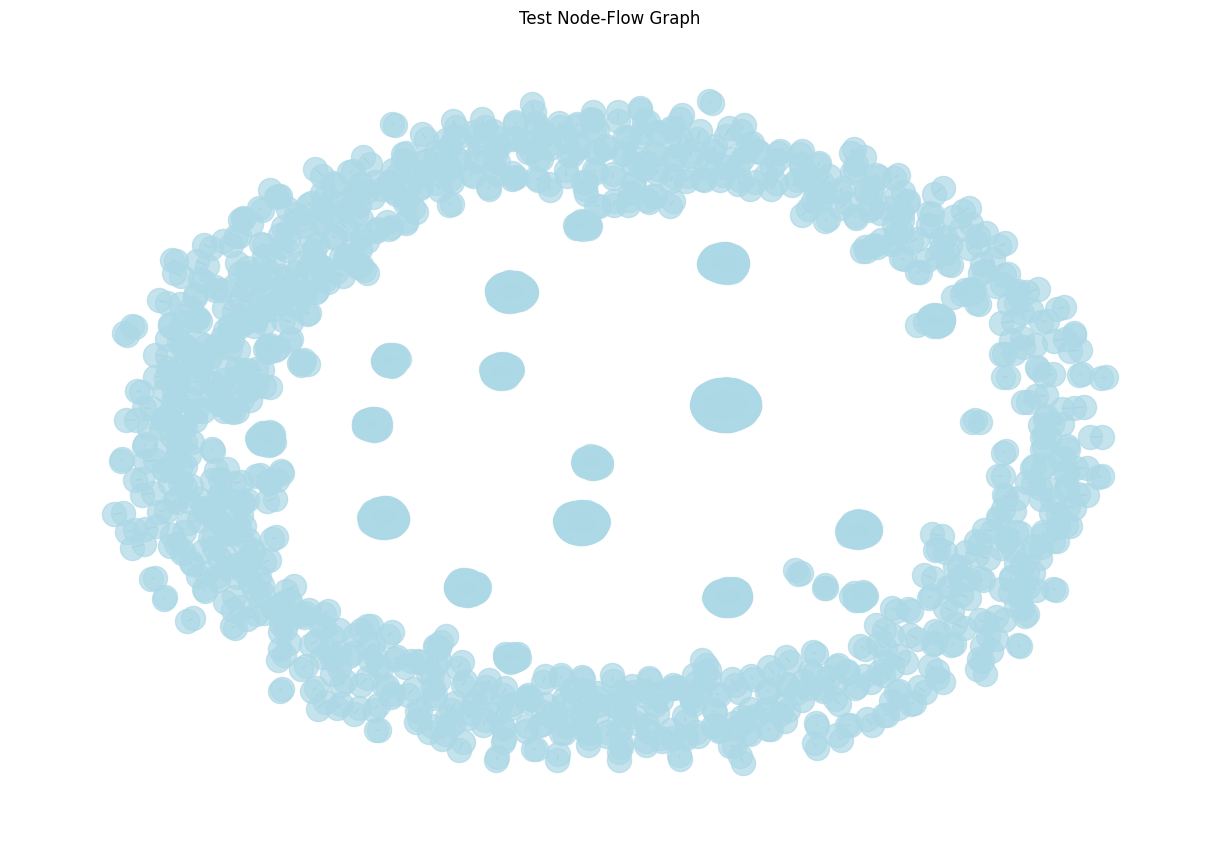

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(graph, title, save_path=None):
    """
    Visualize the created graph
    
    Args:
        graph (torch_geometric.data.Data): The graph to be visualized
        title (str): Title of the plot
        save_path (str, optional): Path to save the plot
    """
    G = nx.Graph()

    # Add nodes
    for i in range(graph.x.shape[0]):
        G.add_node(i)

    # Add edges
    for i, j in graph.edge_index.t().tolist():
        G.add_edge(i, j)

    # Plot the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=False, node_color='lightblue', edge_color='gray', alpha=0.7)
    plt.title(title)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

# Example usage
if __name__ == "__main__":
    # Load the saved graphs
    train_edge_flow = torch.load('/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/datasets/cicids2017/binary_graphs/train_graph_type2.pt')
    train_node_flow = torch.load('/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/datasets/cicids2017/binary_graphs/train_graph_type1.pt')
    test_edge_flow = torch.load('/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/datasets/cicids2017/binary_graphs/test_graph_type1.pt')
    test_node_flow = torch.load('/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/datasets/cicids2017/binary_graphs/test_graph_type2.pt')

    # Visualize the graphs
    visualize_graph(train_edge_flow, 'Train Edge-Flow Graph', '/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/src/cicids2017/feature_pics/train_edge_flow_binary.png')
    visualize_graph(train_node_flow, 'Train Node-Flow Graph', '/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/src/cicids2017/feature_pics/train_node_flow_binary.png')
    visualize_graph(test_edge_flow, 'Test Edge-Flow Graph', '/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/src/cicids2017/feature_pics/test_edge_flow_binary.png')
    visualize_graph(test_node_flow, 'Test Node-Flow Graph', '/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/src/cicids2017/feature_pics/test_node_flow_binary.png')

In [9]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

def create_heterogeneous_graph(df, binary_classification=False, subgraph_size=1024):
    """
    Create heterogeneous graph with hosts and flows as node types
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    binary_classification (bool): Convert to binary classification
    subgraph_size (int): Size of subgraphs
    
    Returns:
    List of HeteroData graphs
    """
    # Prepare labels
    label_encoder = LabelEncoder()
    if binary_classification:
        df['Label'] = df['Label'].map(lambda x: 1 if x == 'Malicious' else 0)
    labels = label_encoder.fit_transform(df['Label'])
    
    # Prepare unique IPs
    unique_ips = np.unique(np.concatenate([
        df['Source IP'].unique(), 
        df['Destination IP'].unique()
    ]))
    ip_map = {ip: idx for idx, ip in enumerate(unique_ips)}
    
    # Prepare subgraphs
    data = []
    n_subgraphs = len(df) // subgraph_size + (1 if len(df) % subgraph_size > 0 else 0)
    
    for i in range(n_subgraphs):
        start = i * subgraph_size
        end = (i + 1) * subgraph_size
        subgraph = df.iloc[start:end]
        
        # Map source and destination IPs to indices
        src_indices = [ip_map[ip] for ip in subgraph['Source IP']]
        dst_indices = [ip_map[ip] for ip in subgraph['Destination IP']]
        
        # Create heterogeneous graph
        het_graph = HeteroData()
        
        # Host node features (IP-based features)
        het_graph['host'].x = torch.tensor([
            [ip_map[ip], 0, 0, 0, 0] for ip in unique_ips
        ], dtype=torch.float)
        
        # Flow node features
        flow_features_cols = [
            'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 
            'Total Length of Fwd Packets', 'Total Length of Bwd Packets'
        ]
        het_graph['flow'].x = torch.tensor(
            subgraph[flow_features_cols].values, 
            dtype=torch.float
        )
        
        # Labels for flow nodes
        het_graph['flow'].y = torch.tensor(labels[start:end], dtype=torch.long)
        
        # Edges: host to flow
        host_to_flow_edges = torch.tensor([
            [src_indices, list(range(len(subgraph)))],
            [list(range(len(subgraph))), dst_indices]
        ], dtype=torch.long)
        
        het_graph['host', 'flow'].edge_index = host_to_flow_edges[0]
        het_graph['flow', 'host'].edge_index = host_to_flow_edges[1]
        
        data.append(het_graph)
    
    return data

def prepare_dataset(df, binary_classification=False, test_size=0.2, random_state=42, save_path=None):
    """
    Prepare train and test heterogeneous graphs
    
    Parameters:
    df (pd.DataFrame): Input dataframe
    binary_classification (bool): Whether to convert to binary classification
    test_size (float): Proportion of dataset to include in test split
    random_state (int): Random state for reproducibility
    save_path (str, optional): Directory to save graphs
    
    Returns:
    tuple: (train_graphs, test_graphs)
    """
    # Preprocess data
    df = df.dropna()
    
    # Split data
    train_df, test_df = train_test_split(
        df, test_size=test_size, random_state=random_state, 
        stratify=df['Label']
    )
    
    # Create heterogeneous graphs
    train_graphs = create_heterogeneous_graph(
        train_df, 
        binary_classification=binary_classification
    )
    test_graphs = create_heterogeneous_graph(
        test_df, 
        binary_classification=binary_classification
    )
    
    # Optional: Save graphs
    if save_path:
        import os
        os.makedirs(save_path, exist_ok=True)
        
        # Save train and test graphs
        torch.save(train_graphs, os.path.join(save_path, 'train_graphs_hetero.pt'))
        torch.save(test_graphs, os.path.join(save_path, 'test_graphs_hetero.pt'))
    
    return train_graphs, test_graphs

# Example usage
if __name__ == "__main__":
    # Create synthetic data
    # np.random.seed(42)
    # data = {
    #     'Source IP': np.random.randint(1, 255, 100),
    #     'Destination IP': np.random.randint(1, 255, 100),
    #     'Flow Duration': np.random.randint(10, 1000, 100),
    #     'Total Fwd Packets': np.random.randint(1, 50, 100),
    #     'Total Backward Packets': np.random.randint(1, 50, 100),
    #     'Total Length of Fwd Packets': np.random.rand(100) * 1000,
    #     'Total Length of Bwd Packets': np.random.rand(100) * 1000,
    #     'Label': np.random.choice(['Malicious', 'Benign', 'Suspicious'], 100)
    # }
    sampled_df = pd.read_csv('/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/datasets/cicids2017/all_data.csv')
    
    # Prepare heterogeneous graphs
    train_graphs, test_graphs = prepare_dataset(
        sampled_df, 
        binary_classification=True,
        save_path='/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/datasets/cicids2017/binary_graphs'
    )
    
    # Print graph information
    print(f"Number of train graphs: {len(train_graphs)}")
    print(f"First graph host features: {train_graphs[0]['host'].x.shape}")
    print(f"First graph flow features: {train_graphs[0]['flow'].x.shape}")

/tmp/ipykernel_2036/2906630450.py:139: DtypeWarning: Columns (84) have mixed types. Specify dtype option on import or set low_memory=False.
  sampled_df = pd.read_csv('/teamspace/studios/this_studio/Anomoly_Threat_Detection_using_GNNs/datasets/cicids2017/all_data.csv')


Number of train graphs: 2089
First graph host features: torch.Size([9687, 5])
First graph flow features: torch.Size([1024, 5])
